# Simple exploit

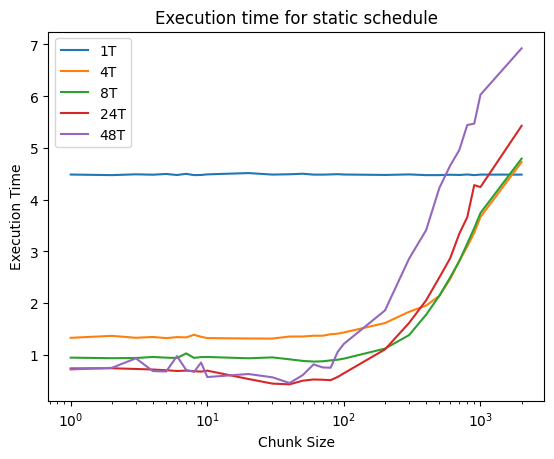

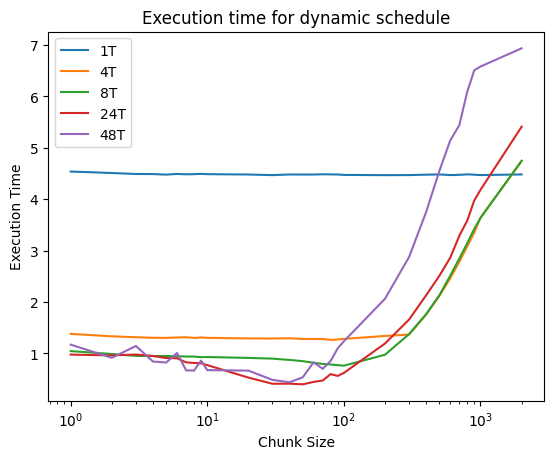

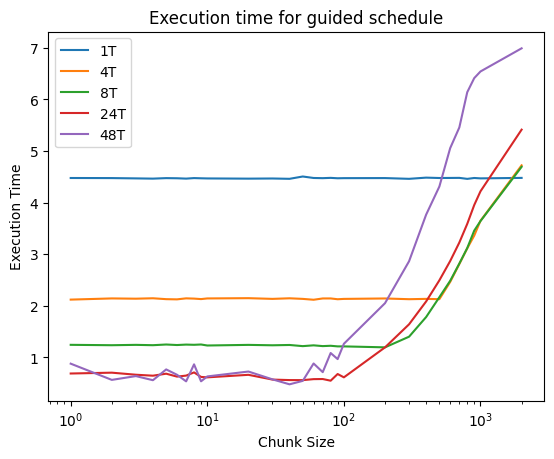

In [2]:



import matplotlib.pyplot as plt
import numpy as np

import json

file = 'results.json'
# file = 'results-nowrite.json'


# Load dictionary from a JSON file
with open(file, 'r') as json_file:
    results_dict = json.load(json_file)

# Print the loaded dictionary
# print(results_dict)


for mode in results_dict["Schedule_mode"]:
    # for thread_num in results_dict["Thread_sweep"]:
    for thread_num in [1, 4, 8, 24, 48]:
        plt.plot(results_dict["Schedule_chunks"], [results_dict["MT"][str(thread_num)][mode][str(i)] for i in results_dict["Schedule_chunks"]],
                label=f'{thread_num}T')
    plt.xlabel("Chunk Size")
    plt.ylabel("Execution Time")
    plt.title(f'Execution time for {mode} schedule')
    plt.legend()
    plt.xscale('log')
    plt.savefig(f'figs/write/ET_{mode}.png')
    plt.show()




# Chunk-based Speedup



In [3]:
# BROKEN FOR SOME REASON

# ref_time = [results_dict["MT"]["1"][mode][str(i)] for i in results_dict["Schedule_chunks"]]
# # ref_time = [results_dict["ST"] for _ in results_dict["Schedule_chunks"]]
# # Use MT with 1T as ref as OpenMP add an optimization layer to singlethreaded too


# for mode in results_dict["Schedule_mode"]:
#     for thread_num in [1, 4, 8, 24, 48]:
#     # for thread_num in results_dict["Thread_sweep"]:
#         plt.plot(results_dict["Schedule_chunks"], [ref_time[i]/results_dict["MT"][str(thread_num)][mode][str(i)] for i in results_dict["Schedule_chunks"]],
#                 label=f'{thread_num}T')
#     plt.xlabel("Chunk Size")
#     plt.ylabel("Speed-up")
#     plt.title(f'Chunk-based speed-up for {mode} schedule')
#     plt.legend()
#     plt.xscale('log')
#     plt.show()

# Thread-based Speed-up

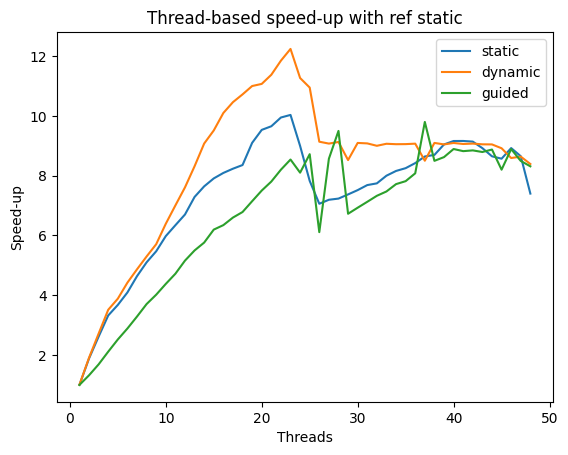

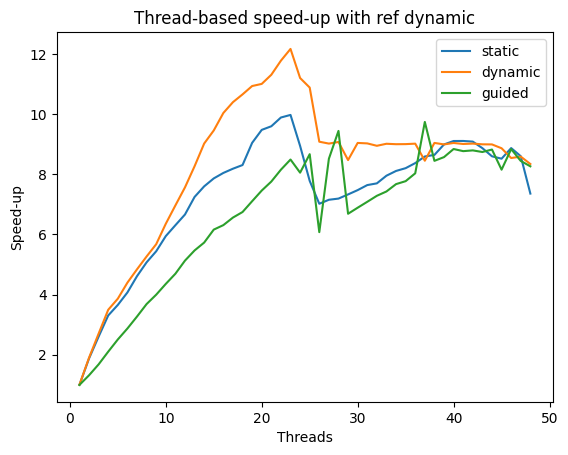

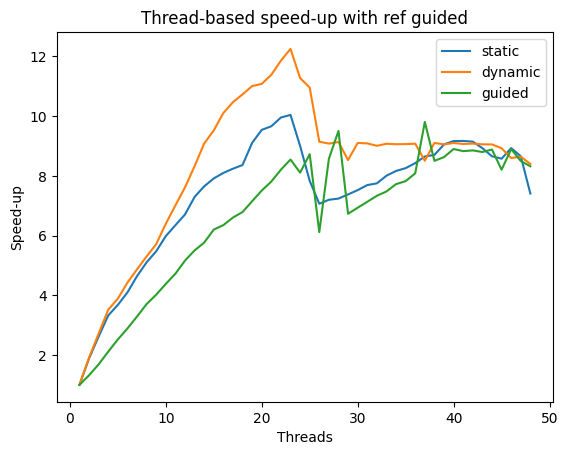

In [4]:
chunk = '50' # seems the best

for ref_mode in results_dict["Schedule_mode"]:
    ref_time = results_dict["MT"]["1"][ref_mode][chunk]
    # ref_time = [results_dict["ST"] for _ in results_dict["Schedule_chunks"]]
    # Use MT with 1T as ref as OpenMP add an optimization layer to singlethreaded too

    for mode in results_dict["Schedule_mode"]:

        l = [ref_time/results_dict["MT"][str(thread_num)][mode][chunk] for thread_num in results_dict["Thread_sweep"]]
        plt.plot(results_dict["Thread_sweep"], l, label=f'{mode}')
    plt.xlabel("Threads")
    plt.ylabel("Speed-up")
    plt.title(f'Thread-based speed-up with ref {ref_mode}')
    plt.legend()
    plt.savefig(f'figs/write/TB_SU_ref-{ref_mode}.png')
    plt.show()


# Heatmaps

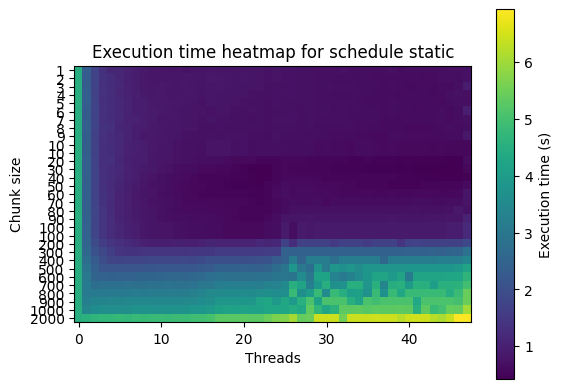

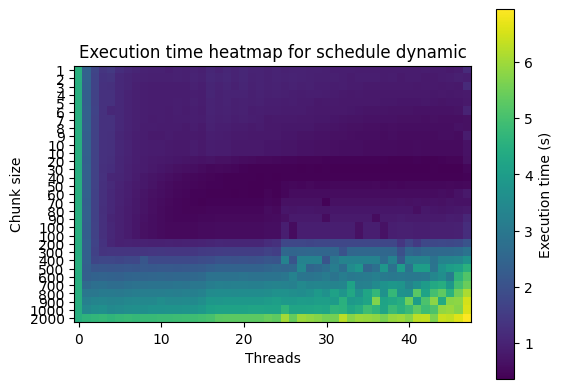

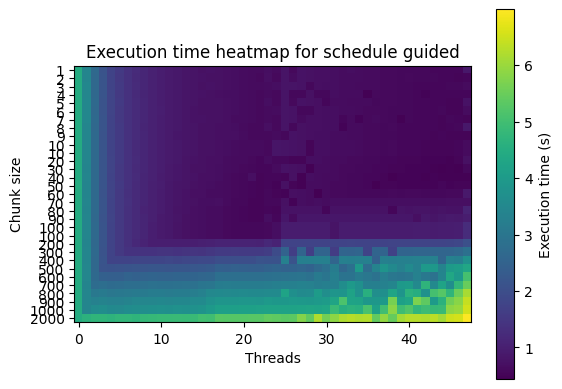

{'static': 0.423891544342041, 'dynamic': 0.36779356002807617, 'guided': 0.44017934799194336}
Minimum Value: 0.36779356002807617
Key: dynamic
Coordinates (x, y): (22, 14)
Recommended setup : 
export OMP_SCHEDULE="dynamic,50"
export OMP_NUM_THREADS=23


In [5]:
import numpy as np

heat_dic = {}
min_dict = {}

for mode in results_dict["Schedule_mode"]:
    mode_matrix = []
    for thread_num in results_dict["Thread_sweep"]:
        l = [results_dict["MT"][str(thread_num)][mode][str(chunk)] for chunk in results_dict["Schedule_chunks"] ]
        mode_matrix.append(l)

    heat_dic[mode] = np.array(mode_matrix)
    min_dict[mode] = np.min(np.array(mode_matrix))

    plt.imshow(heat_dic[mode].T)
    plt.yticks(ticks=np.arange(len(results_dict["Schedule_chunks"])), labels=results_dict["Schedule_chunks"])
    plt.colorbar(label="Execution time (s)")
    plt.ylabel("Chunk size")
    plt.xlabel("Threads")
    plt.title(f'Execution time heatmap for schedule {mode}')
    plt.savefig(f'figs/write/Heat_{mode}.png')
    plt.show()



# Optimal parameters finder

global_min = float('inf')
min_key = None
min_coords = (None, None)

# Iterate through the dictionary
for key, matrix in heat_dic.items():
    min_value = np.min(matrix)  # Find the minimum value in the matrix
    if min_value < global_min:
        global_min = min_value
        min_key = key
        min_coords = np.unravel_index(np.argmin(matrix), matrix.shape)  # Get (x, y) coordinates

# Output results
print(min_dict)
print(f"Minimum Value: {global_min}")
print(f"Key: {min_key}")
print(f"Coordinates (x, y): {min_coords}")
print(f'Recommended setup : \nexport OMP_SCHEDULE="{min_key},{results_dict["Schedule_chunks"][min_coords[1]]}"\nexport OMP_NUM_THREADS={min_coords[0]+1}')

with open('figs/write_opt.json', 'w') as json_file:
    json.dump(min_dict, json_file, indent=4)




# Efficiency Analysis

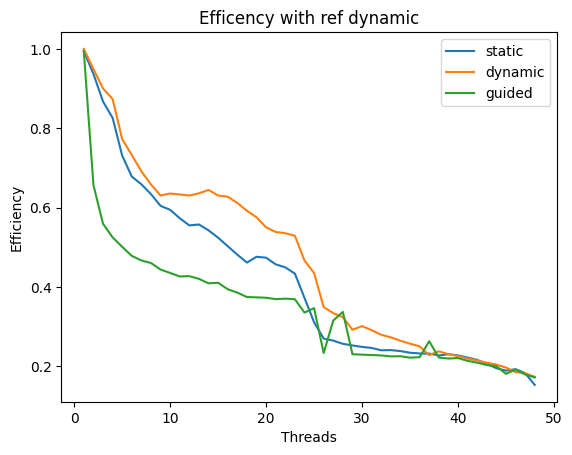

In [14]:
chunk = '50' # seems the best
ref_mode = "dynamic"


ref_time = results_dict["MT"]["1"][ref_mode][chunk]
# ref_time = [results_dict["ST"] for _ in results_dict["Schedule_chunks"]]
# Use MT with 1T as ref as OpenMP add an optimization layer to singlethreaded too

for mode in results_dict["Schedule_mode"]:

    l = [ref_time/results_dict["MT"][str(thread_num)][mode][chunk]/thread_num for thread_num in results_dict["Thread_sweep"]]
    plt.plot(results_dict["Thread_sweep"], l, label=f'{mode}')
plt.xlabel("Threads")
plt.ylabel("Efficiency")
plt.title(f'Efficency with ref {ref_mode}')
plt.legend()
plt.savefig(f'figs/write/TB_SU_ref-{ref_mode}.png')
plt.show()